# The Multipoles of the BOSS DR12 Dataset

In this notebook, we use the ``ConvolvedFFTPower`` algorithm to compute the monopole, quadrupole, and hexadecapole of the BOSS DR12 LOWZ South Galactic Cap (SGC) galaxy sample. This data set is described in detail in [Reid et al. 2016](https://arxiv.org/abs/1509.06529), and the cosmological results for the BOSS DR12 data are presented in [Alam et al. 2017](https://arxiv.org/abs/1607.03155). 

Here, we measure the power spectrum multipoles for the SGC LOWZ sample due to its relatively small size, such that this notebook can be executed in reasonable time on a laptop. The analysis presented in this notebook can easily be applied to the BOSS DR12 CMASS sample and samples in both the North and South Galactic Cap regions. 

The BOSS dataset includes both the "data" and the "randoms" catalogs, each of which includes FKP weights, completeness weights, and $n(z)$ values. This notebook illustrates how to incorporate these analysis steps into the power spectrum analysis using nbodykit. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

import os
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
setup_logging() # turn on logging to screen

## Getting the Data

The BOSS DR12 galaxy data sets are available for download on the [SDSS DR12 homepage](http://www.sdss.org/dr12/data_access/). The "data" and "randoms" catalogs for the North Galactic CMASS sample are available from the following links:

- data: https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_LOWZ_South.fits.gz (32.3 MB)
- randoms: https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_LOWZ_South.fits.gz (713.3 MB) 

Below, we've included a function to download these data files a directory of your choosing. The files will only be downloaded if they have not yet been downloaded.

In [4]:
def print_download_progress(count, block_size, total_size):
    import sys
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_data(download_dir):
    """
    Download the FITS data needed for this notebook to the specified directory.
    
    Parameters
    ----------
    download_dir : str
        the data will be downloaded to this directory
    """
    from six.moves import urllib
    import shutil
    import gzip
    
    urls = ['https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_LOWZ_South.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_LOWZ_South.fits.gz']
    filenames = ['galaxy_DR12v5_LOWZ_South.fits', 'random0_DR12v5_LOWZ_South.fits']
    
    # download both files
    for i, url in enumerate(urls):
        
        # the download path
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)
        final_path = os.path.join(download_dir, filenames[i])
        
        # do not re-download
        if not os.path.exists(final_path):
            print("Downloading %s" % url)
            
            # Check if the download directory exists, otherwise create it.
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)

            # Download the file from the internet.
            file_path, _ = urllib.request.urlretrieve(url=url,
                                                      filename=file_path,
                                                      reporthook=print_download_progress)

            print()
            print("Download finished. Extracting files.")

            # unzip the file
            with gzip.open(file_path, 'rb') as f_in, open(final_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(file_path)
            print("Done.")
        else:
            print("Data has already been downloaded.")

In [5]:
# download the data to the current directory
download_dir = "."
download_data(download_dir)

Data has already been downloaded.
Data has already been downloaded.


## Loading the Data from Disk

The "data" and "randoms" catalogs are stored on disk as FITS objects, and we can use the ``FITSCatalog`` object to read the data from disk.

Note that the IO operations are performed on-demand, so no data is read from disk until an algorithm requires it to be read. For more details, see the [On-Demand IO](../catalogs/on-demand-io.rst) section of the documentation.


**Note**

To specify the directory where the BOSS catalogs were downloaded, change the ``path_to_catalogs`` variable below.

In [6]:
# NOTE: change this path if you downloaded the data somewhere else!
data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')

# initialize the FITS catalog objects for data and randoms
data = FITSCatalog(data_path)
randoms = FITSCatalog(randoms_path)

[ 000001.32 ]   0: 08-03 17:15  CatalogSource   INFO     Extra arguments to FileType: ('./galaxy_DR12v5_LOWZ_South.fits',)


[ 000001.32 ]   0: 08-03 17:15  CatalogSource   INFO     Extra arguments to FileType: ('./random0_DR12v5_LOWZ_South.fits',)


We can analyze the available columns in the catalogs via the ``columns`` attribute:

In [7]:
print('data columns = ', data.columns)

data columns =  ['AIRMASS', 'CAMCOL', 'COMP', 'DEC', 'DEVFLUX', 'EB_MINUS_V', 'EXPFLUX', 'EXTINCTION', 'FIBER2FLUX', 'FIBERID', 'FIELD', 'FINALN', 'FRACPSF', 'ICHUNK', 'ICOLLIDED', 'ID', 'IMAGE_DEPTH', 'IMATCH', 'INGROUP', 'IPOLY', 'ISECT', 'MJD', 'MODELFLUX', 'MULTGROUP', 'NZ', 'PLATE', 'PSFFLUX', 'PSF_FWHM', 'RA', 'RERUN', 'RUN', 'R_DEV', 'SKYFLUX', 'SPECTILE', 'Selection', 'TILE', 'Value', 'WEIGHT_CP', 'WEIGHT_FKP', 'WEIGHT_NOZ', 'WEIGHT_SEEING', 'WEIGHT_STAR', 'WEIGHT_SYSTOT', 'Weight', 'Z']


In [8]:
print('randoms columns = ', randoms.columns)

randoms columns =  ['AIRMASS', 'DEC', 'EB_MINUS_V', 'IMAGE_DEPTH', 'IPOLY', 'ISECT', 'NZ', 'PSF_FWHM', 'RA', 'SKYFLUX', 'Selection', 'Value', 'WEIGHT_FKP', 'Weight', 'Z', 'ZINDX']


## Select the Correct Redshift Range

The LOWZ galaxy sample is defined over a redshift range of $0.15 < z < 0.43$, in order to not overlap with the CMASS sample. First, we will slice our input catalogs to the proper redshift using the ``Z`` column. 

When manipulating loaded data, it is usually best to trim the loaded data via slice operations first before any additional columns or data cleaning is performed. 

In [9]:
ZMIN = 0.15
ZMAX = 0.43

# slice the randoms
valid = (randoms['Z'] > ZMIN)&(randoms['Z'] < ZMAX)
randoms = randoms[valid]

# slice the data
valid = (data['Z'] > ZMIN)&(data['Z'] < ZMAX)
data = data[valid]

## Adding the Cartesian Coordinates

Both the "data" and "randoms" catalogs include positions of objects in terms of right ascension, declination, and redshift. Next, we add the ``Position`` column to both catalogs by converting from these sky coordinates to Cartesian coordinates, using the helper function ``transform.SkyToCartesian``. 

To convert from redshift to comoving distance, we use the fiducial DR12 BOSS cosmology, as defined in [Alam et al. 2017](https://arxiv.org/abs/1607.03155).

In [10]:
# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['RA'], data['DEC'], data['Z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['RA'], randoms['DEC'], randoms['Z'], cosmo=cosmo)

## Add the Completeness Weights

Next, we specify the completeness weights for the "data" and "randoms". By construction, there are no systematic variations in the number density of the "randoms", so the completenesss weights are set to unity for all objects. For the "data" catalog, the completeness weights are computed as defined in eq. 48 of [Reid et al. 2016](https://arxiv.org/abs/1509.06529). These weights account for systematic issues, redshift failures, and missing objects due to close pair collisions on the fiber plate. 

In [11]:
randoms['WEIGHT'] = 1.0
data['WEIGHT'] = data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1.0)

## Computing the Multipoles

To compute the multipoles, first we combine the "data" and "randoms" catalogs into a single ``FKPCatalog``, which provides a common interface to the data in both catalogs. Then, we convert this ``FKPCatalog`` to a mesh object, specifying the number of mesh cells per side, as well as the names of the $n(z)$ and weight columns. 

In [12]:
# combine the data and randoms into a single catalog
fkp = FKPCatalog(data, randoms)

We initialize a $256^3$ mesh to paint the density field. Most likely, users will want to increase this number on machines with enough memory in order to avoid the effects of aliasing on the measured multipoles. We set the value to $256^3$ to ensure this notebook runs on most machines. 

We also tell the mesh object that $n(z)$ column via the ``nbar`` keyword, the FKP weight column via the ``fkp_weight`` keyword, and the completeness weight column via the ``comp_weight`` keyword.

In [13]:
mesh = fkp.to_mesh(Nmesh=256, nbar='NZ', fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', window='tsc')

[ 000017.34 ]   0: 08-03 17:15  FKPCatalog      INFO     BoxSize = [ 868. 1635.  919.]


[ 000017.34 ]   0: 08-03 17:15  FKPCatalog      INFO     cartesian coordinate range: [ 304.15007706 -787.61963937 -219.56693168] : [1154.5008732   815.19825493  680.73166297]


[ 000017.34 ]   0: 08-03 17:15  FKPCatalog      INFO     BoxCenter = [729.32547513  13.78930778 230.58236564]


Users can also pass a ``BoxSize`` keyword to the ``to_mesh()`` function in order to specify the size of the Cartesian box that the mesh is embedded in. By default, the maximum extent of the "randoms" catalog sets the size of the box.

Now, we are able to compute the desired multipoles. Here, we compute the $\ell=0,2,$ and $4$ multipoles using a wavenumber spacing of $k = 0.005$ $h/\mathrm{Mpc}$. The maximum $k$ value computed is set by the Nyquist frequency of the mesh, $k_\mathrm{max} = k_\mathrm{Nyq} = \pi N_\mathrm{mesh} / L_\mathrm{box}$.

In [14]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0,2,4], dk=0.005, kmin=0.)

[ 000017.36 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'


[ 000017.36 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'


[ 000027.32 ]   0: 08-03 17:15  CatalogMesh     INFO     painted 5549994 out of 5549994 objects to mesh


[ 000027.33 ]   0: 08-03 17:15  CatalogMesh     INFO     painted 5549994 out of 5549994 objects to mesh


[ 000027.33 ]   0: 08-03 17:15  CatalogMesh     INFO     mean particles per cell is 0.0776352


[ 000027.33 ]   0: 08-03 17:15  CatalogMesh     INFO     sum is 1.3025e+06 


[ 000027.33 ]   0: 08-03 17:15  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000027.74 ]   0: 08-03 17:15  CatalogMesh     INFO     painted 113525 out of 113525 objects to mesh


[ 000027.74 ]   0: 08-03 17:15  CatalogMesh     INFO     painted 113525 out of 113525 objects to mesh


[ 000027.75 ]   0: 08-03 17:15  CatalogMesh     INFO     mean particles per cell is 0.0016465


[ 000027.75 ]   0: 08-03 17:15  CatalogMesh     INFO     sum is 27623.7 


[ 000027.75 ]   0: 08-03 17:15  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000027.80 ]   0: 08-03 17:15  FKPCatalogMesh  INFO     field: (FKPCatalog(species=['data', 'randoms']) as CatalogMesh) painting done


[ 000027.80 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     tsc painting of 'first' done


[ 000028.17 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     ell = 0 done; 1 r2c completed


[ 000031.15 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     normalized power spectrum with `randoms.norm = 2.076940`


[ 000033.27 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     ell = 2 done; 5 r2c completed


/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/nbodykit/algorithms/fftpower.py:616: RuntimeWarning: invalid value encountered in sqrt
  xslab **= 0.5
/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/nbodykit/meshtools.py:136: RuntimeWarning: divide by zero encountered in true_divide
  return sum(self.coords(i) * los[i] for i in range(self.ndim)) / self.norm2()**0.5


[ 000038.22 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     ell = 4 done; 9 r2c completed


[ 000039.10 ]   0: 08-03 17:15  ConvolvedFFTPower INFO     higher order multipoles computed in elapsed time 00:00:07.94


The meta-data computed during the calculation is stored in ``attrs`` dictionary. See [the documentation](http://nbodykit.rtfd.io/en/latest/results/algorithms/survey-power.html#the-meta-data) for more information.

In [15]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

poles = [0, 2, 4]
dk = 0.005
kmin = 0.0
use_fkp_weights = False
P0_FKP = None
Nmesh = [256 256 256]
BoxSize = [ 868. 1635.  919.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [729.32547513  13.78930778 230.58236564]
mesh.window = tsc
mesh.interlaced = False
alpha = 0.021211734643316733
data.norm = 2.0767224
randoms.norm = 2.076939564818603
shotnoise = 3631.26854558135
randoms.N = 5549994
randoms.W = 5549994.0
randoms.num_per_cell = 0.0776351608830188
data.N = 113525
data.W = 117725.0
data.num_per_cell = 0.001646501710638404
data.ext = 1
randoms.ext = 1


The measured multipoles are stored in the ``poles`` attribute. Below, we plot the monopole, quadrupole, and hexadecapole, making sure to subtract out the shot noise value from the monopole.

(0.01, 0.25)

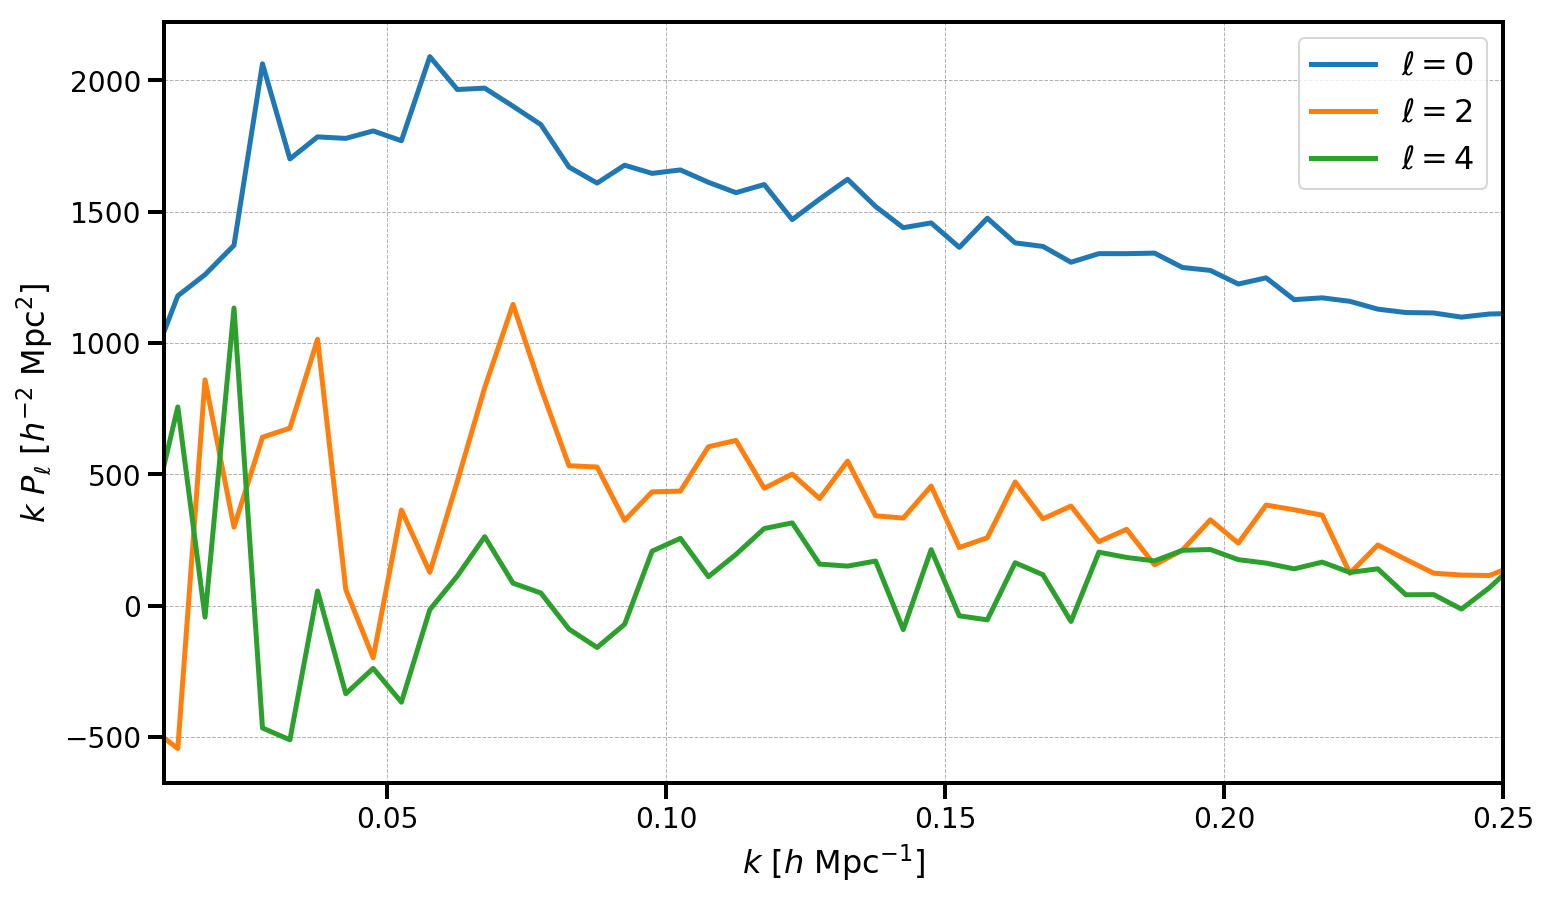

In [16]:
poles = r.poles

for ell in [0, 2, 4]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - r.attrs['shotnoise']
    plt.plot(poles['k'], poles['k']*P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \ P_\ell$ [$h^{-2} \ \mathrm{Mpc}^2$]")
plt.xlim(0.01, 0.25)

For the LOWZ SGC sample, with $N = 113525$ objects, the measured multipoles are noiser than for the other DR12 galaxy samples. Nonetheless, we have measured a clear monopole and quadrupole signal, with the hexadecapole remaining largely consistent with zero.

Note that the results here are measured up to the 1D Nyquist frequency, $k_\mathrm{max} = k_\mathrm{Nyq} = \pi N_\mathrm{mesh} / L_\mathrm{box}$. Users can increase the Nyquist frequency and decrease the effects of aliasing on the measured power by increasing the mesh size. Using interlacing (by setting ``interlaced=True``) can also reduce the effects of aliasing on the measured results. 

## Converting from $P_\ell(k)$ to $P(k,\mu)$

The ``ConvolvedFFTPower.to_pkmu`` function allows users to rotate the measured multipoles, stored as the ``poles`` attribute, into $P(k,\mu)$ wedges. Below, we convert our measurements of $P_0$, $P_2$, and $P_4$ into 3 $\mu$ wedges. 

In [17]:
# use the same number of mu wedges and number of multipoles
Nmu = Nell = 3
mu_edges = numpy.linspace(0, 1, Nmu+1)

# get a BinnedStatistic holding the P(k,mu) wedges
Pkmu = r.to_pkmu(mu_edges, 4)

(0.01, 0.25)

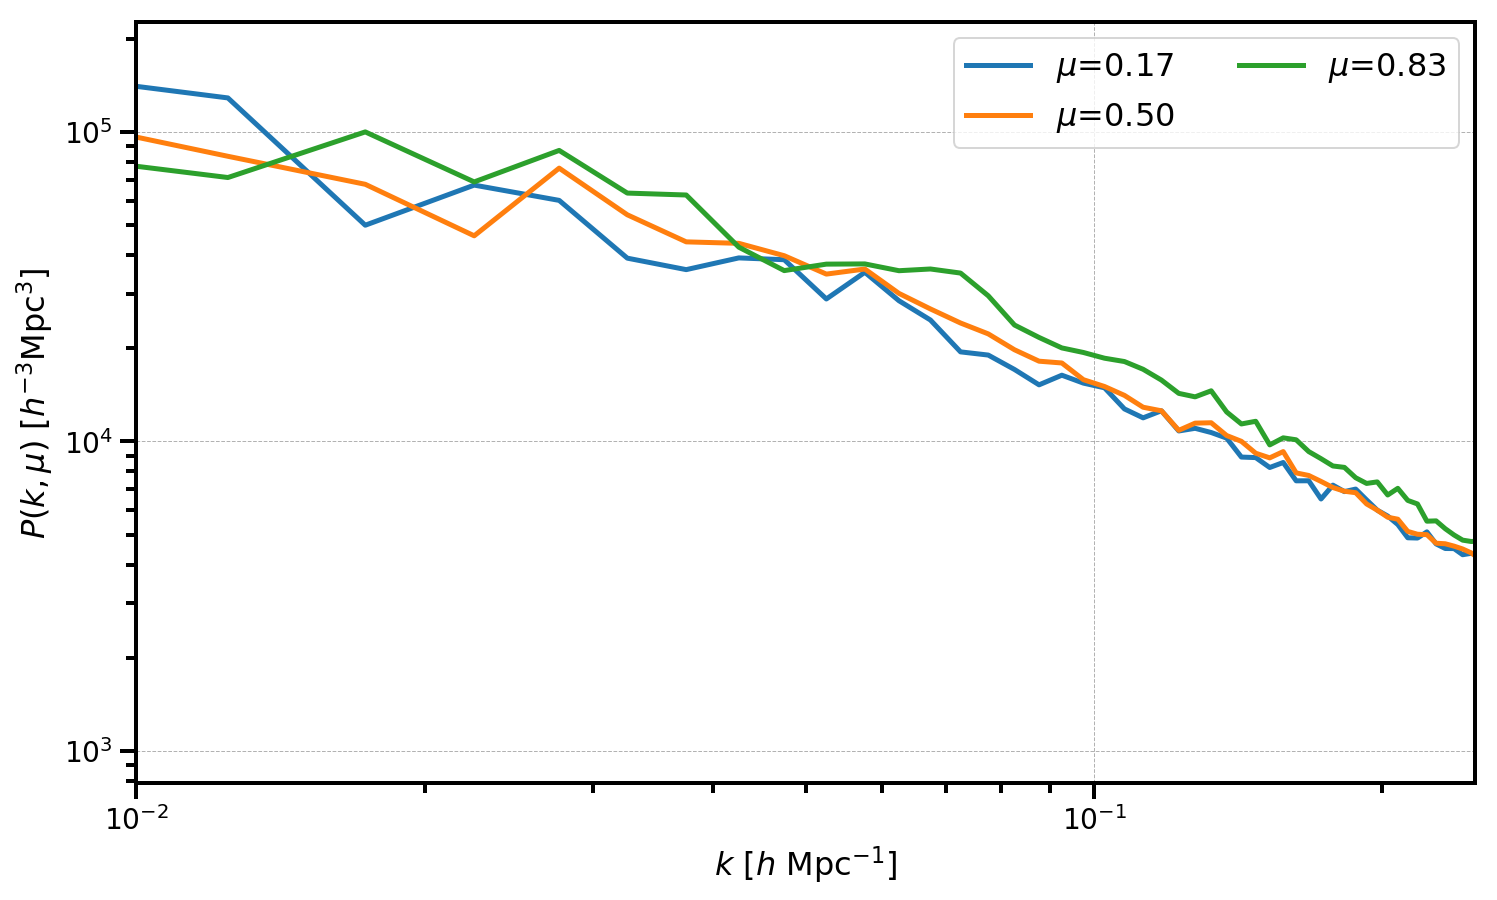

In [18]:
# plot each mu bin
for i in range(Pkmu.shape[1]):
    Pk = Pkmu[:,i] # select the ith mu bin
    label = r'$\mu$=%.2f' % (Pkmu.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)

# format the axes
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.25)